In [33]:
import sys
sys.path.append("../..")
import module.components.CONST as CONST
from module.base.network import Network
from module.simulation.meanfield import MeanField
from module.simulation.quick_meanfield2 import QuickMeanField2
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import scipy
import scipy.odr

/tmp/ipykernel_326/168048005.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
def fft(signal):
    n_0 = int(signal.shape[-1] / 2)
    signal_fft = np.fft.fft(signal)
    freq = np.fft.fftfreq(signal.shape[-1]) / dt * 2 * np.pi

    return freq[0:n_0], signal_fft[0:n_0]

def fft_amp(signal):
    n_0 = int(signal.shape[-1] / 2)
    signal_fft = np.fft.fft(signal)
    freq = np.fft.fftfreq(signal.shape[-1]) / dt * 2 * np.pi

    return freq[0:n_0], np.abs(signal_fft[0:n_0])

def fft_phase(signal):
    n_0 = int(signal.shape[-1] / 2)
    signal_fft = np.fft.fft(signal)
    freq = np.fft.fftfreq(signal.shape[-1]) / dt * 2 * np.pi

    return freq[0:n_0], np.angle(signal_fft[0:n_0])

In [3]:
#dt = 0.001 #zu schnell
dt = 0.01    # fest
t_max = 600
N = int(t_max / dt)
ts = np.linspace(0, t_max, N)
print("N =", N)

N = 60000


In [4]:
sigma_x = 0.1   # std dev of voltage
k = 0.98

In [5]:
def next_U(U):
    return k * U + np.random.randn() * sigma_x * np.sqrt(1 - k**2)

In [6]:
sigma_noise = sigma_x * np.sqrt(1 - k**2)
print(sigma_noise)

0.01989974874213242


In [7]:
Us = [0]
for i in range(N - 1):
    Us.append(next_U(Us[-1]))
Us = np.array(Us)

In [8]:
U_ref = [0]
for i in range(N - 1):
    U_ref.append(next_U(U_ref[-1]))
U_ref = np.array(U_ref)

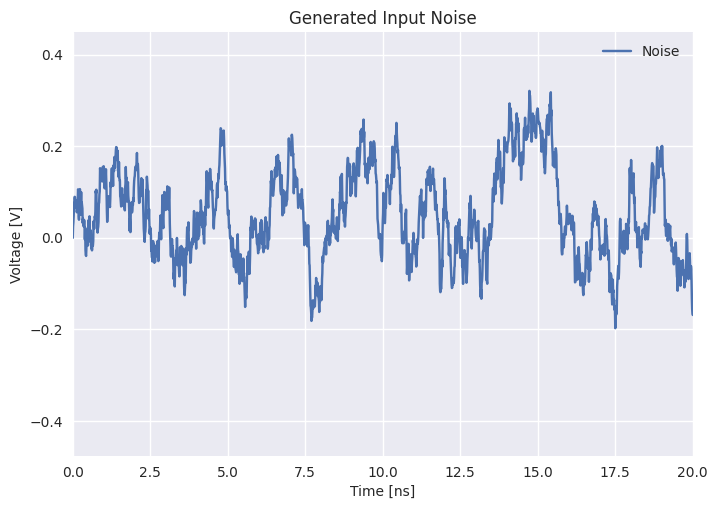

In [9]:
plt.plot(ts, Us, label = "Noise")
plt.xlim(0, 20)
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.title("Generated Input Noise")
plt.savefig("../../output/time_dependence/noise.pdf")

In [10]:
net = Network(3, 3, 1, [[0,0,0], [2,0,0],[0,2,0],[2,2,0]])
qmf2 = QuickMeanField2(net)

In [11]:
Is = []
for i in range(N):
    net.set_voltage_config([Us[i], 0, 0, 0], 0)
    qmf2.numeric_integration_solve(N = 1, dt = dt, reset = False)
    Is.append(qmf2.calc_expected_electrode_current(3))

In [12]:
Is = np.array(Is)

In [14]:
sigma_noise

0.01989974874213242

In [15]:
sigma_noise/dt/dt*np.pi

625.1690445656593

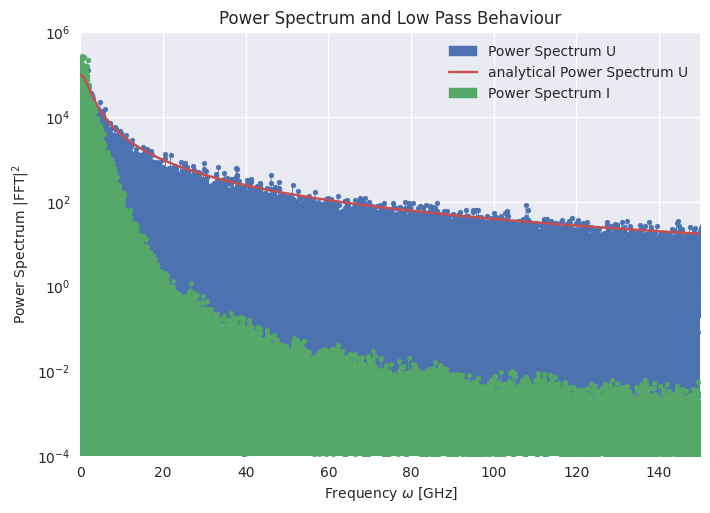

In [74]:
bm = scipy.signal.windows.hann(len(Us))
freq, U_amp = fft_amp(Us * bm)
freq, I_amp = fft_amp(Is * bm)


plt.scatter(freq, U_amp**2, color = "C0", marker = ".")
plt.fill_between(freq, 0, U_amp**2, alpha = 1, color = "C0",  label = "Power Spectrum U")

ws = np.linspace(0, freq[-1], num = 2000)
plt.plot(ws, sigma_noise**2/dt**2/dt**2*np.pi**2/np.sqrt(ws**2 + (1 - k)**2/dt**2)**2, color = "C2", label = "analytical Power Spectrum U")


plt.scatter(freq, I_amp**2, color = "C1", marker = ".", alpha = 1)
plt.fill_between(freq, 0, I_amp**2, alpha = 1, color = "C1", label = "Power Spectrum I")

plt.xlim(0, 150)
plt.ylim(1e-4, 1e6)
plt.yscale("log")
plt.xlabel("Frequency $\\omega$ [GHz]")
plt.ylabel("Power Spectrum $|\\mathrm{FFT}|^2$")
plt.title("Power Spectrum and Low Pass Behaviour")
plt.legend()
plt.savefig("../../output/time_dependence/low_pass.png")

In [45]:
UU_corr = scipy.signal.correlate(Us, Us[:N - 3000], mode ="valid")

In [46]:
I0 = -(Is - np.mean(Is))

IU_corr = scipy.signal.correlate(Us, I0[3000:], mode = "valid")

(0.0, 7.0)

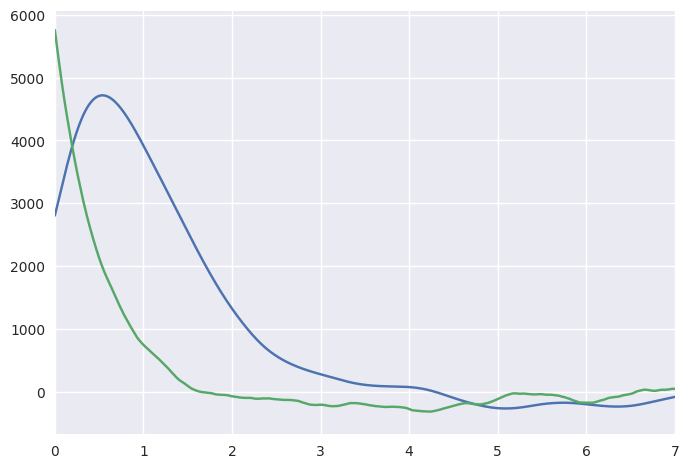

In [47]:
plt.plot(np.arange(len(IU_corr)) * dt, np.flip(IU_corr) / np.sqrt(np.std(Is) * np.std(Us)))
plt.plot(np.arange(len(UU_corr)) * dt, UU_corr / np.std(Us))

plt.xlim(0, 7)

In [48]:
def pears_corr(A, B, min, max):
    N = len(A)
    assert len(B) == N, "inccorect lenghts"

    corr = 1 / (max - min) * scipy.signal.correlate(A, B[min:max], mode = "valid")
    corr = corr - np.mean(A) * np.mean(B)
    corr = corr / np.std(A) / np.std(B)

    return corr

In [49]:
5000*dt

50.0

Max correlation lag: 0.55 ns


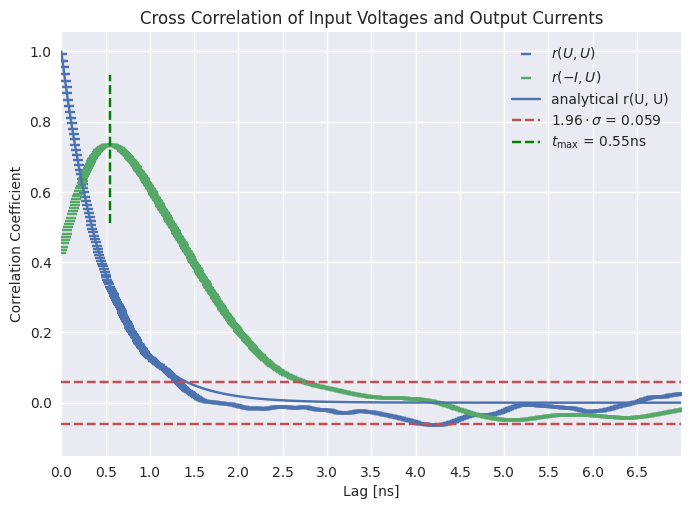

In [179]:
print("Max correlation lag:", np.argmin(np.flip(pears_corr(Us, Is, 5000, N - 1))) * dt, "ns")
lag = np.argmin(np.flip(pears_corr(Us, Is, 1000, N - 1))) * dt

shift = np.arange(5002) * dt

plt.scatter(shift, np.flip(pears_corr(Us, Us, 5000, N - 1)), label = "$r(U,U)$", marker = "_")
plt.scatter(shift, np.flip(pears_corr(Us, -Is, 5000, N - 1)), label = "$r(-I,U)$", marker = "_")
# plt.plot(shift, np.flip(pears_corr(Us, U_ref, 5000, N - 1)), label = "$ref$")
# plt.plot(shift, pears_corr(Is, Is, 11000, N - 1), label = "II")


plt.plot(shift, np.exp(-(1-k)/(dt)*shift), color = "C0", label = "analytical r(U, U)")

plt.axhline(1.96 * np.std(pears_corr(Us, U_ref, 5000, N - 1)), linestyle = "dashed", color = "C2", label = "$1.96\\cdot\\sigma$ = " + '{:2.2}'.format(1.96 * np.std(pears_corr(Us, U_ref, 5000, N - 1))))
plt.axhline(-1.96 * np.std(pears_corr(Us, U_ref, 5000, N - 1)), linestyle = "dashed", color = "C2")

plt.axvline(lag, color = "g", ymin = 0.55, ymax = 0.9, linestyle = "dashed", label = "$t_{\\mathrm{max}}$ = "+'{:2.2}'.format(lag)+"ns")

plt.legend()
plt.xlim(0, 7)
# plt.xlim(-0.5, 10)
plt.xticks(np.arange(14) / 2, np.arange(14)/2)
plt.xlabel("Lag [ns]")
plt.ylabel("Correlation Coefficient")
plt.title("Cross Correlation of Input Voltages and Output Currents")
plt.savefig("../../output/time_dependence/memory.pdf")

In [201]:
def model_(param, x):
    return param[0] * np.exp(param[1] * x)
model = scipy.odr.Model(model_)
data = scipy.odr.RealData(shift[151:329], np.flip(pears_corr(Us, -Is, 5000, N - 1))[151:329], sx = 0.1, sy = 0.1)
res = scipy.odr.ODR(data, model, beta0=[1., -0.5]).run()

param = res.beta
u_param = res.sd_beta

In [202]:
res.pprint()

Beta: [ 4.16864564 -1.52698896]
Beta Std Error: [0.0634162  0.00808828]
Beta Covariance: [[ 1.2894718  -0.16212958]
 [-0.16212958  0.02097606]]
Residual Variance: 0.003118807352421937
Inverse Condition #: 0.019371597556316348
Reason(s) for Halting:
  Sum of squares convergence


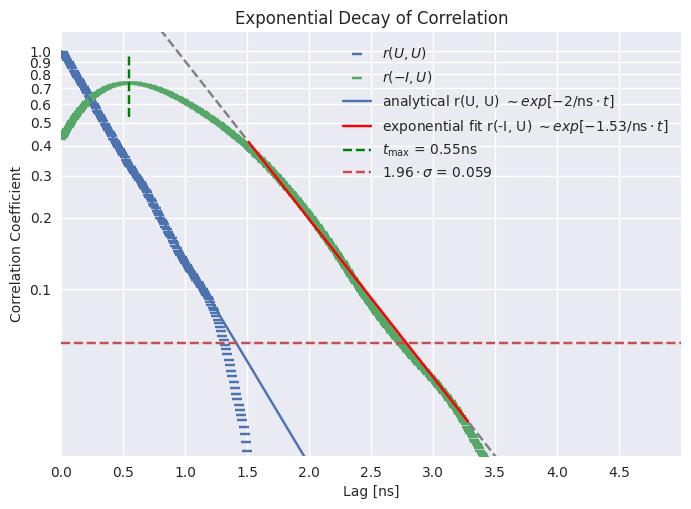

In [215]:
shift = np.arange(5002) * dt

plt.scatter(shift, np.flip(pears_corr(Us, Us, 5000, N - 1)), label = "$r(U,U)$", marker = "_")
# plt.plot(shift, np.flip(pears_corr(Us, -Is, 5000, N - 1)), label = "$r(I,U)$")
plt.scatter(shift, np.flip(pears_corr(Us, -Is, 5000, N - 1)), label = "$r(-I,U)$", marker = "_")
# plt.plot(shift, pears_corr(Is, Is, 11000, N - 1), label = "II")

plt.plot(shift, np.exp(-(1-k)/(dt)*shift), color = "C0", label = "analytical r(U, U) $\\sim exp[-2/\\mathrm{ns} \cdot t]$")

plt.plot(shift[151:329], model_(param, shift)[151:329], color = "red", label = "exponential fit r(-I, U) $\\sim exp[-1.53/\\mathrm{ns} \cdot t]$")
plt.plot(shift[0:151], model_(param, shift)[0:151], color = "gray", linestyle = "dashed")
plt.plot(shift[329:], model_(param, shift)[329:], color = "gray", linestyle = "dashed")

plt.axvline(lag, color = "g", ymin = 0.8, ymax = 0.95, linestyle = "dashed", label = "$t_{\\mathrm{max}}$ = "+'{:2.2}'.format(lag)+"ns")


plt.axhline(1.96 * np.std(pears_corr(Us, U_ref, 5000, N - 1)), linestyle = "dashed", color = "C2", label = "$1.96\\cdot\\sigma$ = " + '{:2.2}'.format(1.96 * np.std(pears_corr(Us, U_ref, 5000, N - 1))))
plt.axhline(-1.96 * np.std(pears_corr(Us, U_ref, 5000, N - 1)), linestyle = "dashed", color = "C2")

plt.legend()
plt.xlim(0, 5)
plt.ylim(2e-2, 1.2)
plt.xticks(np.arange(10) / 2, np.arange(10)/2)
plt.yscale("log")
plt.yticks(np.linspace(0.1, 1, num = 10), np.round(np.linspace(0.1, 1, num = 10) * 10)/10)
plt.xlabel("Lag [ns]")
plt.ylabel("Correlation Coefficient")
plt.title("Exponential Decay of Correlation")
plt.savefig("../../output/time_dependence/shifted_correlation.pdf")

In [212]:
print("IU decay:", param[1], u_param[1])

IU decay: -1.5269889567315296 0.00808828138810975


In [213]:
print("auto_corr_time:", 1 / 2, "ns")
print("cross_corr_time:", -1/param[1], 1/param[1]**2 * u_param[1] ,"ns")

auto_corr_time: 0.5 ns
cross_corr_time: 0.6548835835332218 0.003468841524177216 ns


In [214]:
np.where(shift < 3.3)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177